# Julia Krysiak
We focus on models in the form 

$$ y \sim \mathrm{Normal}(\alpha+X\beta,\sigma) $$



In [2]:
from cmdstanpy import CmdStanModel


import arviz as az
import numpy as np
import scipy.stats as stats

import matplotlib.pyplot as plt
import pandas as pd

/usr/local/lib/python3.9/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


## Excercise 1 - modelling height of !Kung people

### Normal model - no predictors
We will try to fit $\mathrm{Normal}(\mu,\sigma)$ distribution to height data. Special case of linear model with $\beta=0$.

In [3]:
_BASE_URL = "https://raw.githubusercontent.com/rmcelreath/rethinking/Experimental/data"
HOWELL_DATASET_PATH = f"{_BASE_URL}/Howell1.csv"
d = pd.read_csv(HOWELL_DATASET_PATH, sep=';', header=0)
d=d[d.age>=18] #just adults 
d.head()

,height,weight,age,male
0,151.765,47.825606,63.0,1
1,139.700,36.485807,63.0,0
2,136.525,31.864838,65.0,0
3,156.845,53.041914,41.0,1
4,145.415,41.276872,51.0,0


## Task 1. Prior predictive checks

```stan
generated quantities {
    real mu;
    real sigma;
    real height;

    mu = normal_rng(170, 10);       
    sigma = normal_rng(15, 5);      
    height = normal_rng(mu, sigma); 

}
```

In [31]:
model_ppc=CmdStanModel(stan_file='height_1_ppc.stan')

R = 1000
sim=model_ppc.sample(iter_sampling=R,
                     iter_warmup=0,
                     chains=1,
                     fixed_param=True,
                     seed=29042020,refresh=R)

INFO:cmdstanpy:compiling stan file /home/DA/height_1_ppc.stan to exe file /home/DA/height_1_ppc
INFO:cmdstanpy:compiled model executable: /home/DA/height_1_ppc
INFO:cmdstanpy:CmdStan start processing
chain 1 |██████████| 00:00 Sampling completed


INFO:cmdstanpy:CmdStan done processing.




1. Plot histograms of mu, sigma and simulated height.
2. Plot a joint distribution of mu and sigma.
3. Check if samples are consistent with priors.
4. Correct prior parameters to make them reasonably spreaded out. 
5. Check if observed data is possible to obtain using priors.

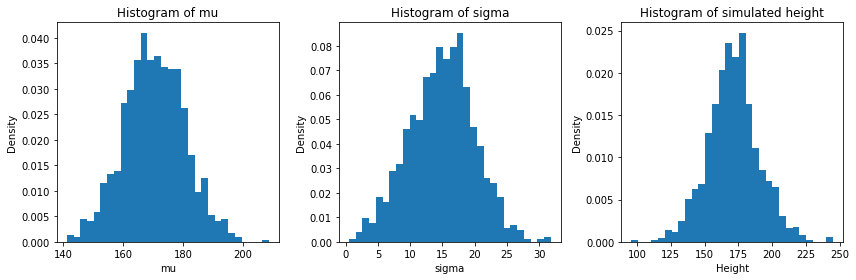

In [33]:
import matplotlib.pyplot as plt

# Extracting samples
mu_samples = sim.stan_variable("mu")
sigma_samples = sim.stan_variable("sigma")
height_samples = sim.stan_variable("height")

# Plot histograms
plt.figure(figsize=(12, 4))

plt.subplot(1, 3, 1)
plt.hist(mu_samples, bins=30, density=True)
plt.title("Histogram of mu")
plt.xlabel("mu")
plt.ylabel("Density")

plt.subplot(1, 3, 2)
plt.hist(sigma_samples, bins=30, density=True)
plt.title("Histogram of sigma")
plt.xlabel("sigma")
plt.ylabel("Density")

plt.subplot(1, 3, 3)
plt.hist(height_samples, bins=30, density=True)
plt.title("Histogram of simulated height")
plt.xlabel("Height")
plt.ylabel("Density")

plt.tight_layout()
plt.show()

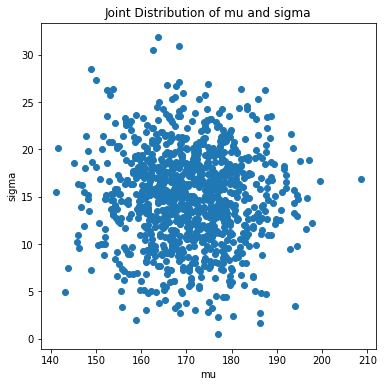

In [34]:
plt.figure(figsize=(6, 6))
plt.scatter(mu_samples, sigma_samples)
plt.title("Joint Distribution of mu and sigma")
plt.xlabel("mu")
plt.ylabel("sigma")
plt.show()

## Task 2. Model fit and evaluation

```stan
data{
    int N;
    array[N] real heights;
}

parameters {
   real mu;
   real<lower=0> sigma;
}
model {
    mu ~ normal(170, 10);       
    sigma ~ normal(10, 5);      
    heights ~ normal(mu, sigma); 
}

generated quantities {
   real height = normal_rng(mu, sigma);
}
```

In [7]:
model_1_fit=CmdStanModel(stan_file='height_1_fit.stan')

INFO:cmdstanpy:found newer exe file, not recompiling


In [8]:
fit=model_1_fit.sample(data=dict(N=len(d),
                                   heights=d.height.values),
                         seed=28052020)

INFO:cmdstanpy:CmdStan start processing
chain 1 |          | 00:00 Status


chain 1 |████████▏ | 00:00 Iteration: 1500 / 2000 [ 75%]  (Sampling)


chain 1 |██████████| 00:00 Sampling completed                       
chain 2 |██████████| 00:00 Sampling completed                       
chain 3 |██████████| 00:00 Sampling completed                       
chain 4 |██████████| 00:00 Sampling completed                       


INFO:cmdstanpy:CmdStan done processing.



1. Plot a joint distribution of fitted mu and sigma.
2. Plot histograms of data and simulated heights and evaluate the quality of model.


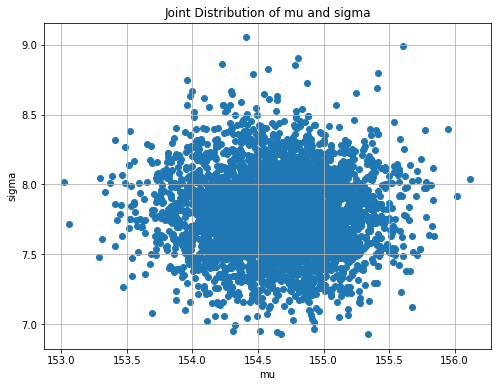

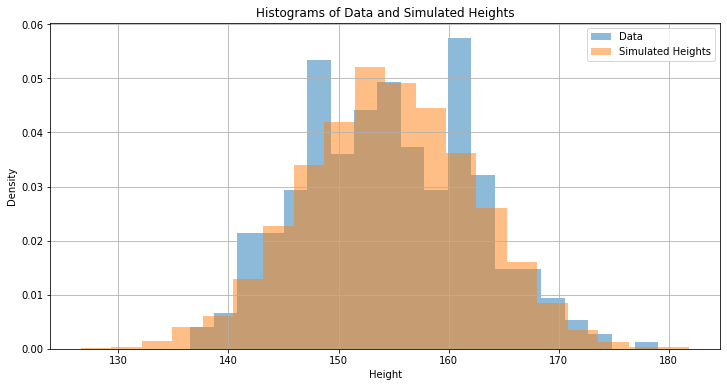

In [9]:
mu_samples = fit.stan_variable('mu')
sigma_samples = fit.stan_variable('sigma')
simulated_heights = fit.stan_variable('height')

plt.figure(figsize=(8, 6))
plt.scatter(mu_samples, sigma_samples)
plt.xlabel('mu')
plt.ylabel('sigma')
plt.title('Joint Distribution of mu and sigma')
plt.grid(True)
plt.show()

plt.figure(figsize=(12, 6))
plt.hist(d.height.values, bins=20, density=True, alpha=0.5, label='Data')
plt.hist(simulated_heights, bins=20, density=True, alpha=0.5, label='Simulated Heights')
plt.xlabel('Height')
plt.ylabel('Density')
plt.title('Histograms of Data and Simulated Heights')
plt.legend()
plt.grid(True)
plt.show()

## Task 3. Adding predictor to the model - weight

Create column ```c_weight``` in the dataframe containing weights substrated by their mean.


In [10]:
mean_weight = d['weight'].mean()
d['c_weight'] = d['weight'] - mean_weight

data_sim={'N':50, 'weight':np.linspace(d.c_weight.min(),d.c_weight.max())}


## Task 4. Prior predictive checks
 

```stan
data{
    int N;
    array[N] real weight;
}
generated quantities {
    real alpha;
    real beta;
    real sigma;
    array[N] real height;

    alpha = normal_rng(170, 10);       
    sigma = normal_rng(15, 5);
    beta = normal_rng(0, 1);
    for (i in 1:N){
        height[i] = normal_rng(alpha + beta*weight[i], sigma);
    }      
}
```

In [49]:
model_ppc=CmdStanModel(stan_file='height_2a_ppc.stan')
R = 1000
sim=model_ppc.sample(data=data_sim, 
                     iter_sampling=R, 
                     iter_warmup=0, 
                     chains=1, 
                     refresh=R,
                     fixed_param=True,
                     seed=29042020)

INFO:cmdstanpy:compiling stan file /home/DA/height_2a_ppc.stan to exe file /home/DA/height_2a_ppc
INFO:cmdstanpy:compiled model executable: /home/DA/height_2a_ppc
INFO:cmdstanpy:CmdStan start processing
chain 1 |██████████| 00:00 Sampling completed                      


INFO:cmdstanpy:CmdStan done processing.


Plot lines for each sampled slope beta and intercept alpha, verify if possible predicted heights are consistent with minimum (0) and maximum (check Wikipedia) heights observed in nature.

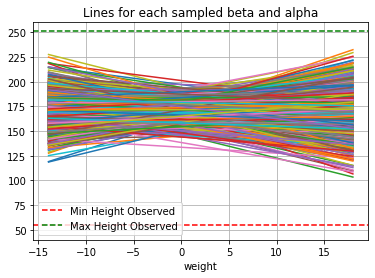

In [51]:
alphas = sim.stan_variable('alpha')
betas = sim.stan_variable('beta')
weight = data_sim['weight']

for alpha, beta in zip(alphas, betas):
 plt.plot(weight, weight * beta + alpha)
plt.xlabel('weight')

# Check consistency with minimum and maximum heights observed in nature

min_height_observed = 55  # minimum observed height 
max_height_observed = 251  # maximum observed height
plt.axhline(y=min_height_observed, color='red', linestyle='--', label='Min Height Observed')
plt.axhline(y=max_height_observed, color='green', linestyle='--', label='Max Height Observed')
plt.ylim([40, 260])
plt.grid(True)
plt.legend()
plt.title("Lines for each sampled beta and alpha")
plt.show()


## Task 5. Modifying prior

If prior for beta admits negative values, then it makes no sense. Lets change prior to lognormal distribution.


```stan
data{
    int N;
    array[N] real weight;
}
generated quantities {
    real alpha;
    real beta;
    real sigma;
    array[N] real height;

    alpha = normal_rng(170, 10);       
    sigma = normal_rng(15, 5);
    beta = lognormal_rng(0, 0.4);
    for (i in 1:N){
        height[i] = normal_rng(alpha + beta*weight[i], sigma);
    }      
}

```

In [64]:
model_ppc=CmdStanModel(stan_file='height_2b_ppc.stan')

INFO:cmdstanpy:compiling stan file /home/DA/height_2b_ppc.stan to exe file /home/DA/height_2b_ppc
INFO:cmdstanpy:compiled model executable: /home/DA/height_2b_ppc


In [65]:
sim=model_ppc.sample(data=data_sim, 
                     iter_sampling=R, 
                     iter_warmup=0, 
                     chains=1, 
                     refresh=R,
                     fixed_param=True,
                     seed=29042020)

INFO:cmdstanpy:CmdStan start processing
chain 1 |          | 00:00 Status

chain 1 |██████████| 00:00 Sampling completed                      


INFO:cmdstanpy:CmdStan done processing.


1. Plot lines for each sampled slope beta and intercept alpha, verify if possible predicted heights are consistent with minimum (0) and maximum (check Wikipedia) heights observed in nature.
2. For each simulated weight plot maximum, minimum, and 5, 25, 50, 75, 95 quantiles of simulated weight (all in the same plot). Compare with observed data. Is observed data possible within the prior model?

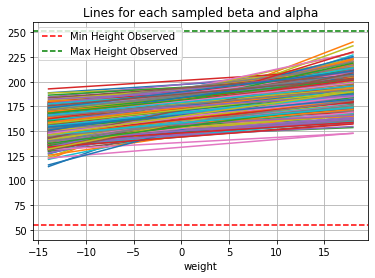

In [66]:
alphas = sim.stan_variable('alpha')
betas = sim.stan_variable('beta')
weight = data_sim['weight']

for alpha, beta in zip(alphas, betas):
 plt.plot(weight, weight * beta + alpha)
plt.xlabel('weight')

# Check consistency with minimum and maximum heights observed in nature

min_height_observed = 55  # minimum observed height 
max_height_observed = 251  # maximum observed height

plt.axhline(y=min_height_observed, color='red', linestyle='--', label='Min Height Observed')
plt.axhline(y=max_height_observed, color='green', linestyle='--', label='Max Height Observed')
plt.ylim([40, 260])
plt.grid(True)
plt.legend()
plt.title("Lines for each sampled beta and alpha")
plt.show()

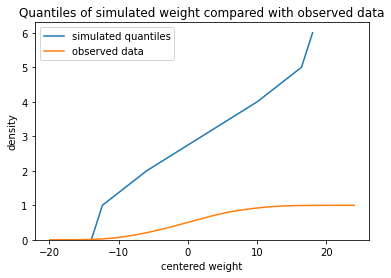

In [68]:
import seaborn as sns

quantiles = np.percentile(data_sim['weight'], [0, 5, 25, 50, 75, 95, 100])
plt.plot(quantiles, np.arange(len(quantiles)), label='simulated quantiles')
sns.kdeplot(data=d['c_weight'], cumulative=True, label='observed data')
plt.title('Quantiles of simulated weight compared with observed data')
plt.xlabel('centered weight')
plt.ylabel('density')
plt.legend()
plt.show()


## Task 6. Fitting and evaluating model


```stan
data{
    int N;
    array[N] real heights;
    array[N] real weight;
}

parameters {
   real alpha;
   real beta;
   real<lower=0> sigma;
}
transformed parameters {
   array[N] real mu;
   for (i in 1:N) {
    mu[i] = alpha + beta*weight[i];
   }
}
model {
    alpha ~ normal(170, 10);       
    sigma ~ normal(10, 5);   
    beta ~ lognormal(0, 0.4);   
    heights ~ normal(mu, sigma); 
}

generated quantities {
   array[N] real height;
   for (i in 1:N){
    height[i] = normal_rng(mu[i], sigma);
   }
}

```

In [83]:
model_2_fit=CmdStanModel(stan_file='height_2_fit.stan')

INFO:cmdstanpy:compiling stan file /home/DA/height_2_fit.stan to exe file /home/DA/height_2_fit
INFO:cmdstanpy:compiled model executable: /home/DA/height_2_fit


1. Create ```data_fit``` dictionary containing data from  ```N``` first rows of dataframe


In [90]:
N=100
data_fit = {'N':N, 'heights': d['height'].head(N).tolist(),'weight': d['weight'].head(N).tolist()}

fit=model_2_fit.sample(data=data_fit,seed=28052020)

INFO:cmdstanpy:CmdStan start processing
chain 1 |          | 00:00 Status


chain 1 |▍         | 00:00 Status


chain 1 |██▎       | 00:00 Iteration:  300 / 2000 [ 15%]  (Warmup)


chain 1 |█████     | 00:00 Iteration:  900 / 2000 [ 45%]  (Warmup)


chain 1 |██████▊   | 00:00 Iteration: 1200 / 2000 [ 60%]  (Sampling)

chain 1 |████████▋ | 00:00 Iteration: 1600 / 2000 [ 80%]  (Sampling)



chain 1 |██████████| 00:00 Sampling completed                       
chain 2 |██████████| 00:00 Sampling completed                       
chain 3 |██████████| 00:00 Sampling completed                       
chain 4 |██████████| 00:00 Sampling completed                       

INFO:cmdstanpy:CmdStan done processing.


2. Plot lines for each sampled slope beta and intercept alpha. Verify how uncertainity changes with increasing of sample (N)
2. For each value of weight plot mean simulated height along with errorbar of one standard deviation (use ```errorbar``` from matplotlib). Compare with observed data (N points). Is observed data possible within the posterior model? What changes when N increases.


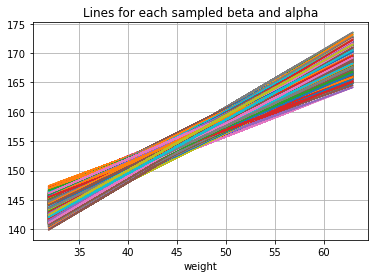

In [91]:
alphas = fit.stan_variable('alpha')
betas = fit.stan_variable('beta')
weight = np.array(data_fit['weight'])

for alpha, beta in zip(alphas, betas):
 plt.plot(weight, weight * beta + alpha)
plt.xlabel('weight')


plt.grid(True)
plt.title("Lines for each sampled beta and alpha")
plt.show()

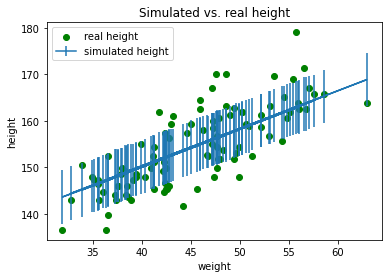

In [92]:
heights = fit.stan_variable('height')
mean_heights = np.mean(heights,axis=0,)
std_heights = np.std(heights,axis=0)
real_heights = np.array(data_fit['heights'])
plt.errorbar(weight, mean_heights, yerr=std_heights, label='simulated height')
plt.scatter(weight, real_heights,label='real height', color ='green')
plt.xlabel('weight')
plt.ylabel('height')
plt.title('Simulated vs. real height')
plt.legend()
plt.show()

## Task 7. Extending the model

1. Center the weight data (substract mean vaule of weight from all values). Test how model works for such data. What is the interpretation of $\alpha$ in such case?
2. Using centered data modify your model with a second power of weight, select prior for its coefficient using prior predictive checks and after fitting check if model is still good.
3. Try to vectorize the model to avoid necessity of a for loop in the ```model``` block. 

In [93]:
data={'N':100, 'heights': d['height'].head(N).tolist(),'weight':d['c_weight'].head(N).tolist()}
fit=model_2_fit.sample(data=data,seed=28052020)

INFO:cmdstanpy:CmdStan start processing
chain 1 |          | 00:00 Status



chain 1 |▉         | 00:00 Iteration:    1 / 2000 [  0%]  (Warmup)


chain 1 |███████▎  | 00:00 Iteration: 1300 / 2000 [ 65%]  (Sampling)

chain 1 |██████████| 00:00 Sampling completed                       
chain 2 |██████████| 00:00 Sampling completed                       
chain 3 |██████████| 00:00 Sampling completed                       
chain 4 |██████████| 00:00 Sampling completed                       


INFO:cmdstanpy:CmdStan done processing.


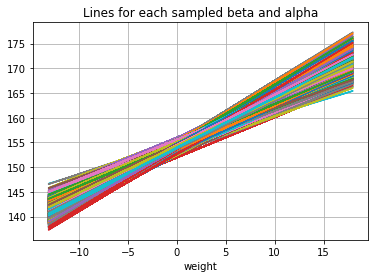

In [95]:
alphas = fit.stan_variable('alpha')
betas = fit.stan_variable('beta')
weight = np.array(data['weight'])

for alpha, beta in zip(alphas, betas):
 plt.plot(weight, weight * beta + alpha)
plt.xlabel('weight')


plt.grid(True)
plt.title("Lines for each sampled beta and alpha")
plt.show()

### Alpha represents expected height for a person with average weight.

```stan
data{
    int N;
    array[N] real heights;
    array[N] real weight;
}

parameters {
   real alpha;
   real beta;
   real gamma;
   real<lower=0> sigma;
}
transformed parameters {
   array[N] real mu;
   for (i in 1:N) {
    mu[i] = alpha + beta * weight[i] + gamma * weight[i]^2;
   }
}
model {
    alpha ~ normal(170, 10);       
    sigma ~ normal(10, 5);   
    beta ~ lognormal(0, 0.4);
    gamma ~ normal(0, 0.01); 
    heights ~ normal(mu, sigma); 
}

generated quantities {
   array[N] real height;
   for (i in 1:N){
    height[i] = normal_rng(mu[i], sigma);
   }
}
```

In [120]:
model_ppc=CmdStanModel(stan_file='height_2c_ppc.stan')

INFO:cmdstanpy:compiling stan file /home/DA/height_2c_ppc.stan to exe file /home/DA/height_2c_ppc
INFO:cmdstanpy:compiled model executable: /home/DA/height_2c_ppc


In [121]:
sim=model_ppc.sample(data=data_sim, 
                     iter_sampling=R, 
                     iter_warmup=0, 
                     chains=1, 
                     refresh=R,
                     fixed_param=True,
                     seed=29042020)

INFO:cmdstanpy:CmdStan start processing
chain 1 |██████████| 00:00 Sampling completed


INFO:cmdstanpy:CmdStan done processing.


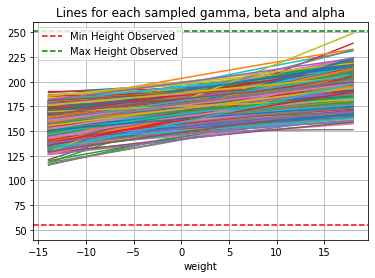

In [122]:
alphas = sim.stan_variable('alpha')
betas = sim.stan_variable('beta')
gammas = sim.stan_variable('gamma')
weight = data_sim['weight']

for alpha, beta, gamma in zip(alphas, betas, gammas):
 plt.plot(weight, weight**2 * gamma + weight * beta + alpha)
plt.xlabel('weight')

# Check consistency with minimum and maximum heights observed in nature

min_height_observed = 55  # minimum observed height 
max_height_observed = 251  # maximum observed height

plt.axhline(y=min_height_observed, color='red', linestyle='--', label='Min Height Observed')
plt.axhline(y=max_height_observed, color='green', linestyle='--', label='Max Height Observed')
plt.ylim([40, 260])
plt.grid(True)
plt.legend()
plt.title("Lines for each sampled gamma, beta and alpha")
plt.show()

In [123]:
model_3_fit=CmdStanModel(stan_file='height_2_fit_gamma.stan')

INFO:cmdstanpy:found newer exe file, not recompiling


In [124]:
N=100
data_fit = {'N':N, 'heights': d['height'].head(N).tolist(),'weight': d['weight'].head(N).tolist()}

fit=model_3_fit.sample(data=data_fit,seed=28052020)

INFO:cmdstanpy:CmdStan start processing
chain 1 |          | 00:00 Status







chain 1 |▉         | 00:00 Iteration:    1 / 2000 [  0%]  (Warmup)




chain 1 |█▎        | 00:00 Iteration:  100 / 2000 [  5%]  (Warmup)


chain 1 |█▊        | 00:00 Iteration:  200 / 2000 [ 10%]  (Warmup)


chain 1 |██▎       | 00:01 Iteration:  300 / 2000 [ 15%]  (Warmup)
chain 1 |██▋       | 00:01 Iteration:  400 / 2000 [ 20%]  (Warmup)


chain 1 |███▏      | 00:01 Iteration:  500 / 2000 [ 25%]  (Warmup)
chain 1 |███▋      | 00:01 Iteration:  600 / 2000 [ 30%]  (Warmup)


chain 1 |████▌     | 00:01 Iteration:  800 / 2000 [ 40%]  (Warmup)


chain 1 |█████▉    | 00:01 Iteration: 1001 / 2000 [ 50%]  (Sampling)


chain 1 |██████▊   | 00:02 Iteration: 1200 / 2000 [ 60%]  (Sampling)
chain 1 |███████▋  | 00:02 Iteration: 1400 / 2000 [ 70%]  (Sampling)


chain 1 |████████▋ | 00:02 Iteration: 1600 / 2000 [ 80%]  (Sampling)
chain 1 |█████████▌| 00:02 Iteration: 1800 / 2000 [ 90%]  (Sampling)
chain 1 |██████████|


INFO:cmdstanpy:CmdStan done processing.


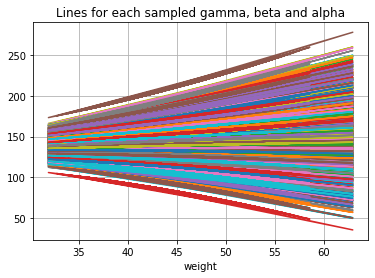

In [125]:
alphas = fit.stan_variable('alpha')
betas = fit.stan_variable('beta')
gammas = sim.stan_variable('gamma')
weight = np.array(data_fit['weight'])

for alpha, beta, gamma in zip(alphas, betas, gammas):
 plt.plot(weight, weight**2 * gamma + weight * beta + alpha)
plt.xlabel('weight')

plt.grid(True)
plt.title("Lines for each sampled gamma, beta and alpha")
plt.show()

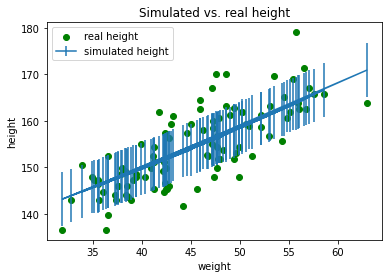

In [126]:
heights = fit.stan_variable('height')
mean_heights = np.mean(heights,axis=0,)
std_heights = np.std(heights,axis=0)
real_heights = np.array(data_fit['heights'])
plt.errorbar(weight, mean_heights, yerr=std_heights, label='simulated height')
plt.scatter(weight, real_heights,label='real height', color ='green')
plt.xlabel('weight')
plt.ylabel('height')
plt.title('Simulated vs. real height')
plt.legend()
plt.show()